Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Pendulum"

In [20]:
import numpy as np
from pendulum_env_extended import PendulumEnvExtended
import matplotlib.pyplot as plt
import random 

In [21]:
env = PendulumEnvExtended(render_mode='rgb_array')

Discretización de los estados

In [22]:
x_space = np.linspace(-1, 1, 10)
y_space = np.linspace(-1, 1, 10)
vel_space = np.linspace(-8, 8, 100)
x_space

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

Obtener el estado a partir de la observación

In [23]:
def get_state(obs):
    x, y, vel = obs
    x_bin = np.digitize(x, x_space)
    y_bin = np.digitize(y, y_space)
    vel_bin = np.digitize(vel, vel_space)
    return x_bin, y_bin, vel_bin

In [24]:
state = get_state(np.array([-0.4, 0.2, 0.3]))
state

(3, 6, 52)

Discretización de las acciones

In [25]:
actions = list(np.linspace(-2, 2, 10))
actions

[-2.0,
 -1.5555555555555556,
 -1.1111111111111112,
 -0.6666666666666667,
 -0.22222222222222232,
 0.22222222222222232,
 0.6666666666666665,
 1.1111111111111107,
 1.5555555555555554,
 2.0]

In [26]:
def get_sample_action():
    return random.choice(actions)

Inicilización de la tabla Q

In [27]:
Q = np.zeros((len(x_space) + 1, len(y_space) + 1, len(vel_space) + 1, len(actions)))
Q

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

Obtención de la acción a partir de la tabla Q

In [28]:
def optimal_policy(state, Q):
    action = actions[np.argmax(Q[state])]
    return action

Epsilon-Greedy Policy

In [29]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = get_sample_action()
    # exploit
    else:
        action = optimal_policy(state, Q)
        
    return action

Ejemplo de episodio 

In [30]:
def get_state(obs):
    x, y, vel = obs
    x_bin = np.digitize(x, x_space)
    y_bin = np.digitize(y, y_space)
    vel_bin = np.digitize(vel, vel_space)
    return x_bin, y_bin, vel_bin

Implemento Q Learning:

In [31]:
def q_learning(env, num_episodes, alpha, gamma, epsilon_start, epsilon_end, epsilon_decay):
    Q = np.zeros((len(x_space) + 1, len(y_space) + 1, len(vel_space) + 1, len(actions)))
    epsilon = epsilon_start
    total_rewards = []
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = get_state(obs)
        done = False
        total_reward = 0
        
        while not done:
            #selecciono la accion con greedy
            action = epsilon_greedy_policy(state, Q, epsilon)
            action_idx = actions.index(action)
            real_action = np.array([action])
            #ejecuto la accion q seleccione en el env
            obs, reward, done, _, _ = env.step(real_action)
            next_state = get_state(obs)
            #actualizo la tabla Q
            next_action_idx = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][next_action_idx]
            td_delta = td_target - Q[state][action_idx]
            Q[state][action_idx] += alpha * td_delta
            #actualizo el estado actual
            state = next_state
            total_reward += reward
        #actualizo (lo bajo) al epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        total_rewards.append(total_reward)
        
        #if (episode + 1) % 100 == 0:
        #    print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")
    
    return Q,total_rewards


In [32]:
Q, total_rewards = q_learning(env, num_episodes=50000, alpha=0.1, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999)

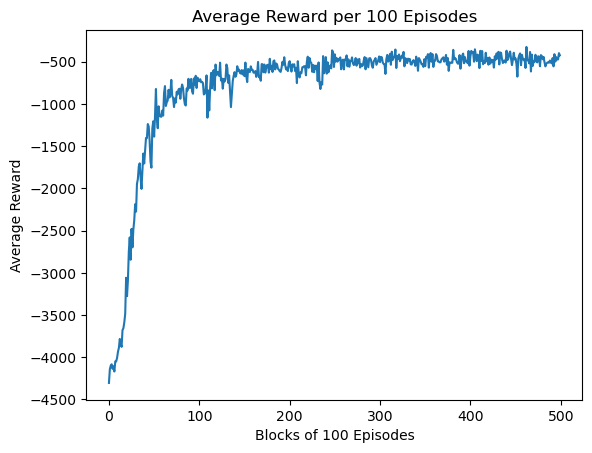

In [33]:
average_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

# Graficar las recompensas promedio
plt.plot(average_rewards)
plt.xlabel('Blocks of 100 Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per 100 Episodes')
plt.show()

In [34]:
def evaluate_policy(env, Q, num_episodes=100):
    total_rewards = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = get_state(obs)
        done = False
        total_reward = 0
        
        while not done:
            action_idx = np.argmax(Q[state])
            action = actions[action_idx]
            real_action = np.array([action])
            obs, reward, done, _, _ = env.step(real_action)
            state = get_state(obs)
            total_reward += reward
        
        total_rewards.append(total_reward)
    
    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    return average_reward


In [35]:
average_reward = evaluate_policy(env, Q)

Average Reward over 100 episodes: -192.03237249171468
